# Gaussian Process on the Wiggle dataset
## Exact inference

# Github

In [ ]:
from google.colab import drive # For github
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Project18/GPs
!git config --global user.email "alexander.sabelstrom.1040@student.uu.se"
!git config --global user.name "Sabelz"

Mounted at /content/drive
/content/drive/MyDrive/Project18/GPs


# Imports

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 15.4 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Project18/datasets


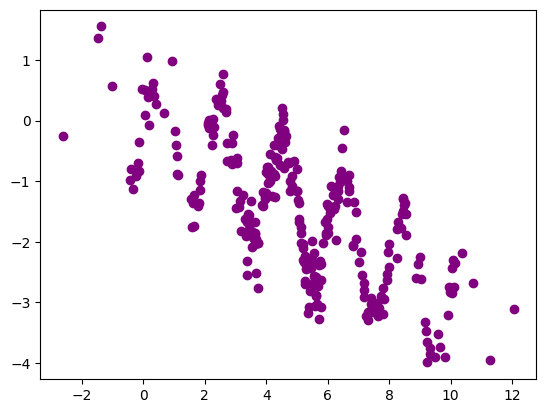

Refresh index: 100% (15/15), done.
On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   ../GPs/GPConcrete.ipynb
	modified:   ../GPs/GPPowerPlant.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
!pip install gpytorch
import gpytorch

%matplotlib inline
%load_ext autoreload
%autoreload 2
%run ../datasets/wiggle.ipynb # Run the wiggle notebook which is in the same folder(Wiggle dataset)


# Training Data from wiggle

In [ ]:
xTrain, yTrain = x, samples # x, samples are defined in ../datasets/wiggle.ipynb
xTrain, yTrain = torch.from_numpy(xTrain), torch.from_numpy(yTrain) # Convert them to tensors

# The GP model

In [ ]:
# Class for the GP model(Exact GP)
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean() # Decide which mean to use
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) # Decide which kernel to use
    # GP Posterior predictive distribution
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize the first model

In [ ]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood() # Decide likelihood
model = GPModel(xTrain, yTrain, likelihood) # For the first example, RBF kernel is used

# Train the Model

In [ ]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 100


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(xTrain)
    # Calc loss and backprop gradients
    loss = -mll(output, yTrain)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/100 - Loss: 1.007   lengthscale: 0.693   noise: 0.693
Iter 2/100 - Loss: 0.962   lengthscale: 0.644   noise: 0.644
Iter 3/100 - Loss: 0.922   lengthscale: 0.602   noise: 0.598
Iter 4/100 - Loss: 0.884   lengthscale: 0.569   noise: 0.554
Iter 5/100 - Loss: 0.849   lengthscale: 0.547   noise: 0.513
Iter 6/100 - Loss: 0.814   lengthscale: 0.536   noise: 0.474
Iter 7/100 - Loss: 0.780   lengthscale: 0.534   noise: 0.437
Iter 8/100 - Loss: 0.746   lengthscale: 0.538   noise: 0.403
Iter 9/100 - Loss: 0.713   lengthscale: 0.549   noise: 0.371
Iter 10/100 - Loss: 0.681   lengthscale: 0.563   noise: 0.341
Iter 11/100 - Loss: 0.649   lengthscale: 0.579   noise: 0.313
Iter 12/100 - Loss: 0.619   lengthscale: 0.597   noise: 0.287
Iter 13/100 - Loss: 0.591   lengthscale: 0.615   noise: 0.263
Iter 14/100 - Loss: 0.563   lengthscale: 0.631   noise: 0.241
Iter 15/100 - Loss: 0.538   lengthscale: 0.644   noise: 0.221
Iter 16/100 - Loss: 0.514   lengthscale: 0.652   noise: 0.202
Iter 17/100 - Los

# Test Data

In [ ]:
# Observing the plot of the wiggle dataset, x varies between -1-12
xTest = torch.linspace(-5, 17, 50)

# The posterior mean, variance and Covariance Matrix

In [ ]:
model.eval() # eval mode is for computing predictions through the model posterior
f_preds = model(xTest) # returns the model posterior distribution p(f* | x*, X, y), for training data X, y
f_mean = f_preds.mean # Predictive mean
f_var = f_preds.variance # Predictive variance
f_covar = f_preds.covariance_matrix # Covariance matrix
print("Mean Dimension: ", f_mean.size())
print()
print("Variance Dimension: ", f_var.size())
print()
print("CovMatrix Dimension ", f_covar.size())

Mean Dimension:  torch.Size([50])

Variance Dimension:  torch.Size([50])

CovMatrix Dimension  torch.Size([50, 50])


# Plots of samples from the GP

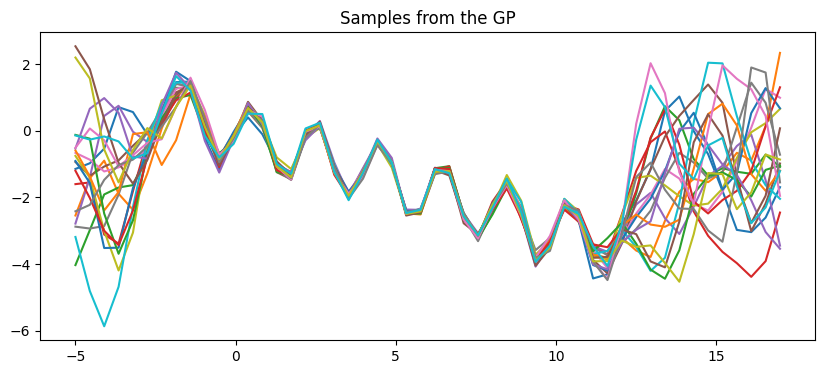

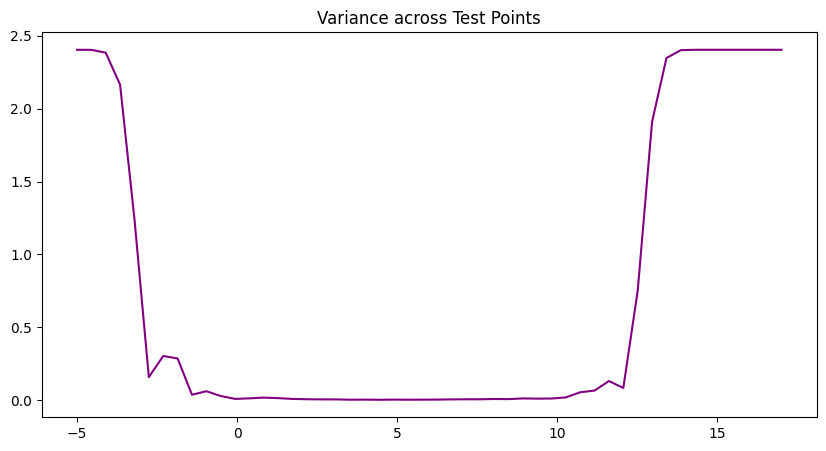

In [ ]:
# Convert to numpy
xTestPlot = xTest.detach().numpy()
f_meanPlot = f_mean.detach().numpy()
f_varPlot = f_var.detach().numpy()
# Plot samples from the GP
plt.figure(figsize=(10, 4))
for i in range(20):  # Generate 20 samples
    f_sample = f_preds.sample().detach().numpy()
    plt.plot(xTestPlot, f_sample)
plt.title('Samples from the GP')
plt.show()
# Plot variance
plt.figure(figsize=(10, 5))
plt.plot(xTestPlot, f_varPlot, 'purple')
plt.title('Variance across Test Points')
plt.show()

# Predictive Distribution

In [ ]:
model.eval() # eval mode is for computing predictions through the model posterior.
likelihood.eval()



# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
    observed_pred = likelihood(model(xTest))# gives us the posterior predictive distribution p(y* | x*, X, y) which is the probability distribution over the predicted output value

# Plot with RBF kernel

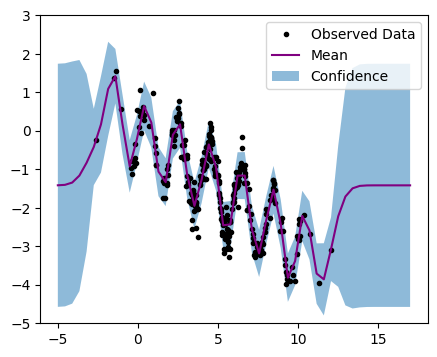

In [215]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(5, 4))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(xTrain.numpy(), yTrain.numpy(), 'k.')
    # Plot predictive means as purple line
    ax.plot(xTest.numpy(), observed_pred.mean.numpy(), 'purple')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(xTest.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-5, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

# GP with a periodic + Linear kernel instead

In [ ]:
# Class for the GP model(Exact GP)
class GPModelPeriodic(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModelPeriodic, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean() # Decide which mean to use
        # This kernel adds the RBF kernel with a Periodic kernel
        self.linear_kernel = gpytorch.kernels.LinearKernel()
        self.periodic_kernel = gpytorch.kernels.PeriodicKernel()
        self.covar_module = gpytorch.kernels.AdditiveKernel(self.periodic_kernel, self.linear_kernel)
    # GP Posterior predictive distribution
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood2 = gpytorch.likelihoods.GaussianLikelihood() # Decide likelihood
modelPeriodic = GPModelPeriodic(xTrain, yTrain, likelihood2) # Now kernel is changed to periodic
# Set the hyperparameters for the Periodic Kernel
modelPeriodic.periodic_kernel.period_length = 6  # Adjust period length as needed
modelPeriodic.periodic_kernel.lengthscale = 0.1  # Adjust magnitude/amplitude of the periodic component
# Ensure these hyperparameters are not trainable
modelPeriodic.periodic_kernel.raw_period_length.requires_grad = False
modelPeriodic.periodic_kernel.raw_lengthscale.requires_grad = False

# Train the periodic model

In [ ]:
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 10

# Find optimal model hyperparameters
modelPeriodic.train()
likelihood2.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(modelPeriodic.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood2, modelPeriodic) # Decide loss


for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = modelPeriodic(xTrain)
    # Calc loss and backprop gradients
    loss = -mll(output, xTrain)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   Periodic lengthscale: %.3f   noise: %.3f  periodLength: %.3f'  % (
    i + 1, training_iter, loss.item(),
    modelPeriodic.periodic_kernel.lengthscale.item(),
    modelPeriodic.likelihood.noise.item(),
    modelPeriodic.periodic_kernel.period_length.item()
))
    optimizer.step()

Iter 1/10 - Loss: 0.836   Periodic lengthscale: 0.100   noise: 0.693  periodLength: 6.000
Iter 2/10 - Loss: 0.802   Periodic lengthscale: 0.100   noise: 0.644  periodLength: 6.000
Iter 3/10 - Loss: 0.767   Periodic lengthscale: 0.100   noise: 0.598  periodLength: 6.000
Iter 4/10 - Loss: 0.731   Periodic lengthscale: 0.100   noise: 0.554  periodLength: 6.000
Iter 5/10 - Loss: 0.695   Periodic lengthscale: 0.100   noise: 0.513  periodLength: 6.000
Iter 6/10 - Loss: 0.658   Periodic lengthscale: 0.100   noise: 0.474  periodLength: 6.000
Iter 7/10 - Loss: 0.620   Periodic lengthscale: 0.100   noise: 0.437  periodLength: 6.000
Iter 8/10 - Loss: 0.582   Periodic lengthscale: 0.100   noise: 0.403  periodLength: 6.000
Iter 9/10 - Loss: 0.543   Periodic lengthscale: 0.100   noise: 0.370  periodLength: 6.000
Iter 10/10 - Loss: 0.503   Periodic lengthscale: 0.100   noise: 0.340  periodLength: 6.000


# The posterior mean, variance and Covariance Matrix

In [ ]:
modelPeriodic.eval() # eval mode is for computing predictions through the model posterior
f_preds2 = modelPeriodic(xTest) # returns the model posterior distribution p(f* | x*, X, y), for training data X, y

f_mean2 = f_preds2.mean # Predictive mean
f_var2 = f_preds2.variance # Predictive variance
f_covar2 = f_preds2.covariance_matrix # Covariance matrix
print("Mean Dimension: ", f_mean2.size())
print()
print("Variance Dimension: ", f_var2.size())
print()
print("CovMatrix Dimension ", f_covar2.size())

Mean Dimension:  torch.Size([50])

Variance Dimension:  torch.Size([50])

CovMatrix Dimension  torch.Size([50, 50])


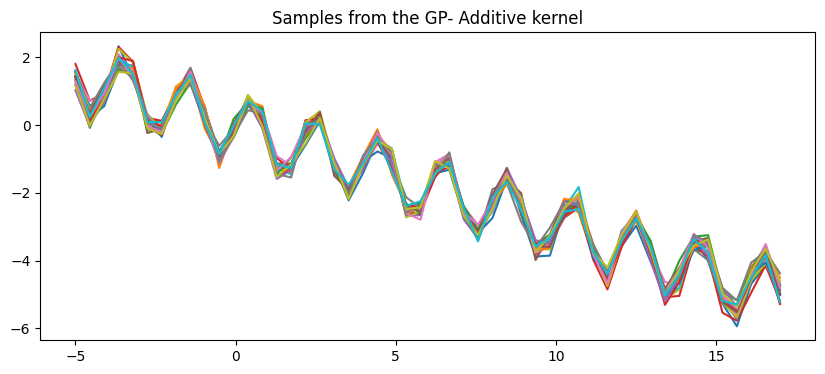

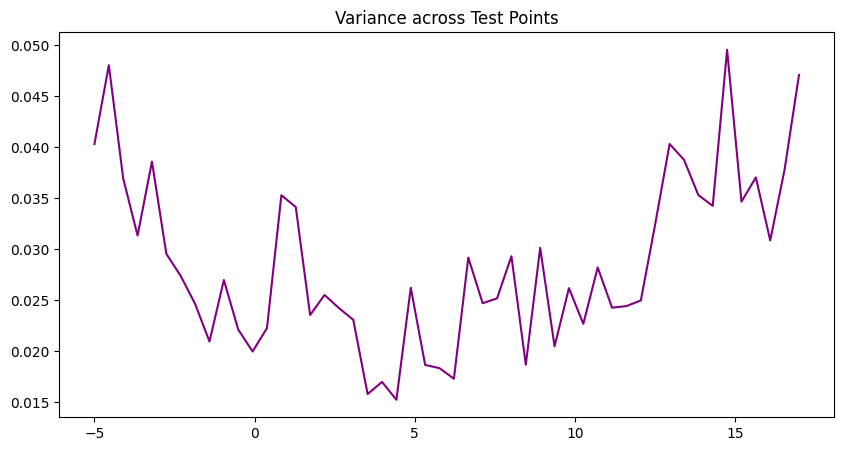

In [ ]:
# Convert to numpy
xTestPlot = xTest.detach().numpy()
f_meanPlot2 = f_mean2.detach().numpy()
f_varPlot2 = f_var2.detach().numpy()
# Plot samples from the GP
plt.figure(figsize=(10, 4))
for i in range(20):  # Generate 20 samples
    f_sample = f_preds2.sample().detach().numpy()
    plt.plot(xTestPlot, f_sample)
plt.title('Samples from the GP- Additive kernel')
plt.show()
# Plot variance
plt.figure(figsize=(10, 5))
plt.plot(xTestPlot, f_varPlot2, 'purple')
plt.title('Variance across Test Points')
plt.show()

# Predictive Distribution

In [ ]:
modelPeriodic.eval() # eval mode is for computing predictions through the model posterior.
likelihood2.eval()
y_preds2 = likelihood2(modelPeriodic(xTest)) # gives us the posterior predictive distribution p(y* | x*, X, y) which is the probability distribution over the predicted output value

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
    observed_pred2 = y_preds2 # ---

# Plot the periodic GP

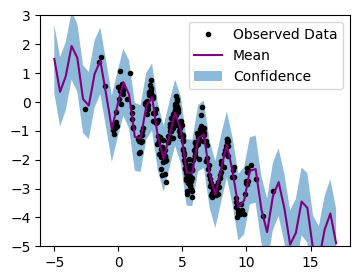

In [217]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred2.confidence_region()
    # Plot training data as black stars
    ax.plot(xTrain.numpy(), yTrain.numpy(), 'k.')
    # Plot predictive means as blue line
    ax.plot(xTest.numpy(), observed_pred2.mean.numpy(), 'purple')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(xTest.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-5, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [ ]:
!ls

inducingPoints.ipynb  toy_data.npy  toy.ipynb  wiggle.ipynb
